# QBC Sensitivity + Stability Analysis

This notebook analyzes one QBC sensitivity run folder, selects the best configuration using a robust objective, and inspects per-round behavior.

In [16]:
from pathlib import Path
import json
import math
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', 200)

# Resolve repo root robustly (works whether notebook cwd is repo root or notebooks/)
CWD = Path.cwd().resolve()
if (CWD / 'outputs').exists() and (CWD / 'run_experiment.py').exists():
    REPO_ROOT = CWD
elif CWD.name == 'notebooks' and (CWD.parent / 'outputs').exists():
    REPO_ROOT = CWD.parent
else:
    # fallback: walk up to find run_experiment.py
    REPO_ROOT = CWD
    for parent in [CWD, *CWD.parents]:
        if (parent / 'run_experiment.py').exists():
            REPO_ROOT = parent
            break

# --- Set this to your run folder name (relative to outputs/qbc_sens) ---
RUN_NAME = 'thesis_sm4_qbc_sens_local_evalrmse_20260225_093141'
RUN_BASE = REPO_ROOT / 'outputs' / 'qbc_sens' / RUN_NAME

assert RUN_BASE.exists(), f'Run base not found: {RUN_BASE}'
print('REPO_ROOT =', REPO_ROOT)
print('RUN_BASE =', RUN_BASE)


REPO_ROOT = /Users/jonaswiendl/local/Repos/ml-surrogates-for-power-systems
RUN_BASE = /Users/jonaswiendl/local/Repos/ml-surrogates-for-power-systems/outputs/qbc_sens/thesis_sm4_qbc_sens_local_evalrmse_20260225_093141


## 1) Load Smoke + Stability Artifacts

In [17]:
selected_path = RUN_BASE / 'selected_top_configs.txt'
ranking_path = RUN_BASE / 'smoke_ranking.csv'
smoke_dir = RUN_BASE / 'smoke'
stability_dir = RUN_BASE / 'stability'

selected_cfgs = []
if selected_path.exists():
    selected_cfgs = [ln.strip() for ln in selected_path.read_text(encoding='utf-8').splitlines() if ln.strip()]

print('selected_top_configs:', selected_cfgs)
print('smoke_ranking.csv exists:', ranking_path.exists())
print('stability dir exists:', stability_dir.exists())

selected_top_configs: ['cfg03_varp90', 'cfg04_l2', 'cfg07_less_diverse']
smoke_ranking.csv exists: True
stability dir exists: True


In [18]:
def load_manifest(run_root: Path):
    p = run_root / 'run_manifest.json'
    if not p.exists():
        return None
    with p.open('r', encoding='utf-8') as f:
        return json.load(f)


def parse_cfg_seed(name: str):
    # expected: cfg07_less_diverse_s05
    m = re.match(r'^(.*)_s(\d+)$', name)
    if not m:
        return name, None
    return m.group(1), f"s{m.group(2)}"


def sum_round_seconds(run_root: Path):
    tp = run_root / 'telemetry' / 'round_telemetry.csv'
    if not tp.exists():
        return np.nan
    t = pd.read_csv(tp)
    if 'round_seconds' not in t.columns:
        return np.nan
    return pd.to_numeric(t['round_seconds'], errors='coerce').sum(skipna=True)

rows = []
if stability_dir.exists():
    for d in sorted(stability_dir.iterdir()):
        if not d.is_dir():
            continue
        m = load_manifest(d)
        if m is None:
            continue
        cfg, seed = parse_cfg_seed(d.name)

        rmse = np.nan
        mse = np.nan
        status = m.get('stages', {}).get('stage3_baseline', {}).get('status', None)
        payload = m.get('artifacts', {}).get('baseline_metrics_payload', {})
        if payload:
            rmse = payload.get('rmse', np.nan)
            mse = payload.get('mse', np.nan)

        rows.append({
            'run_name': d.name,
            'cfg': cfg,
            'seed': seed,
            'run_root': str(d),
            'baseline_status': status,
            'rmse': rmse,
            'mse': mse,
            'total_round_seconds': sum_round_seconds(d),
        })

stability_df = pd.DataFrame(rows)
stability_df = stability_df.sort_values(['cfg', 'seed']).reset_index(drop=True)
print('stability runs loaded:', len(stability_df))
stability_df.head(10)

stability runs loaded: 15


,run_name,cfg,seed,run_root,baseline_status,rmse,mse,total_round_seconds
0,cfg03_varp90_s01,cfg03_varp90,s01,/Users/jonaswiendl/local/Repos/ml-surrogates-f...,completed,0.019157,0.000367,618.839689
1,cfg03_varp90_s02,cfg03_varp90,s02,/Users/jonaswiendl/local/Repos/ml-surrogates-f...,completed,0.021972,0.000483,621.390709
2,cfg03_varp90_s03,cfg03_varp90,s03,/Users/jonaswiendl/local/Repos/ml-surrogates-f...,completed,0.028884,0.000834,586.340047
3,cfg03_varp90_s04,cfg03_varp90,s04,/Users/jonaswiendl/local/Repos/ml-surrogates-f...,completed,0.029279,0.000857,584.130258
4,cfg03_varp90_s05,cfg03_varp90,s05,/Users/jonaswiendl/local/Repos/ml-surrogates-f...,completed,0.025237,0.000637,599.875536
5,cfg04_l2_s01,cfg04_l2,s01,/Users/jonaswiendl/local/Repos/ml-surrogates-f...,completed,0.020862,0.000435,515.898720
6,cfg04_l2_s02,cfg04_l2,s02,/Users/jonaswiendl/local/Repos/ml-surrogates-f...,completed,0.022374,0.000501,560.840273
7,cfg04_l2_s03,cfg04_l2,s03,/Users/jonaswiendl/local/Repos/ml-surrogates-f...,completed,0.020342,0.000414,522.842479
8,cfg04_l2_s04,cfg04_l2,s04,/Users/jonaswiendl/local/Repos/ml-surrogates-f...,completed,0.024504,0.000600,538.506692
9,cfg04_l2_s05,cfg04_l2,s05,/Users/jonaswiendl/local/Repos/ml-surrogates-f...,completed,0.021902,0.000480,511.008460


## 2) Robust Config Scoring and Best-Config Selection

Objective used:

`robust_obj = mean_rmse + 0.5 * std_rmse + 0.03 * log1p(mean_round_seconds)`

Lower is better.

In [19]:
if stability_df.empty:
    raise RuntimeError('No stability runs found. Please check RUN_BASE.')

agg = (
    stability_df
    .groupby('cfg', dropna=False)
    .agg(
        n_seeds=('seed', 'count'),
        mean_rmse=('rmse', 'mean'),
        std_rmse=('rmse', 'std'),
        min_rmse=('rmse', 'min'),
        max_rmse=('rmse', 'max'),
        mean_round_seconds=('total_round_seconds', 'mean'),
    )
    .reset_index()
)

agg['std_rmse'] = agg['std_rmse'].fillna(0.0)
agg['robust_obj'] = agg['mean_rmse'] + 0.5 * agg['std_rmse'] + 0.03 * np.log1p(agg['mean_round_seconds'])
agg = agg.sort_values('robust_obj').reset_index(drop=True)

best_cfg = agg.loc[0, 'cfg']
print('Best config =', best_cfg)
agg

Best config = cfg04_l2


,cfg,n_seeds,mean_rmse,std_rmse,min_rmse,max_rmse,mean_round_seconds,robust_obj
0,cfg04_l2,5,0.021997,0.001617,0.020342,0.024504,529.819325,0.211038
1,cfg07_less_diverse,5,0.023115,0.002813,0.020002,0.027185,515.608797,0.211940
2,cfg03_varp90,5,0.024906,0.004380,0.019157,0.029279,602.115248,0.219159


In [20]:
# Optional sanity: compare against smoke ranking if present
if ranking_path.exists():
    smoke_rank = pd.read_csv(ranking_path)
    display(smoke_rank.head(10))
else:
    print('No smoke_ranking.csv found')

,rank,cfg,rmse,total_round_seconds,objective,run_root
0,1,cfg03_varp90,0.019157,564.986937,0.209314,outputs/qbc_sens/thesis_sm4_qbc_sens_local_eva...
1,2,cfg04_l2,0.020862,564.854764,0.211013,outputs/qbc_sens/thesis_sm4_qbc_sens_local_eva...
2,3,cfg07_less_diverse,0.021332,569.849903,0.211746,outputs/qbc_sens/thesis_sm4_qbc_sens_local_eva...
3,4,cfg02_varmax,0.019404,665.891915,0.214483,outputs/qbc_sens/thesis_sm4_qbc_sens_local_eva...
4,5,cfg01_base,0.024860,645.752348,0.219019,outputs/qbc_sens/thesis_sm4_qbc_sens_local_eva...
5,6,cfg05_no_norm,0.028910,595.451011,0.220640,outputs/qbc_sens/thesis_sm4_qbc_sens_local_eva...
6,7,cfg06_more_diverse,0.032963,601.680386,0.225004,outputs/qbc_sens/thesis_sm4_qbc_sens_local_eva...
7,8,cfg08_committee5,0.023787,1043.775085,0.232333,outputs/qbc_sens/thesis_sm4_qbc_sens_local_eva...


## 3) Seed Sensitivity Plots

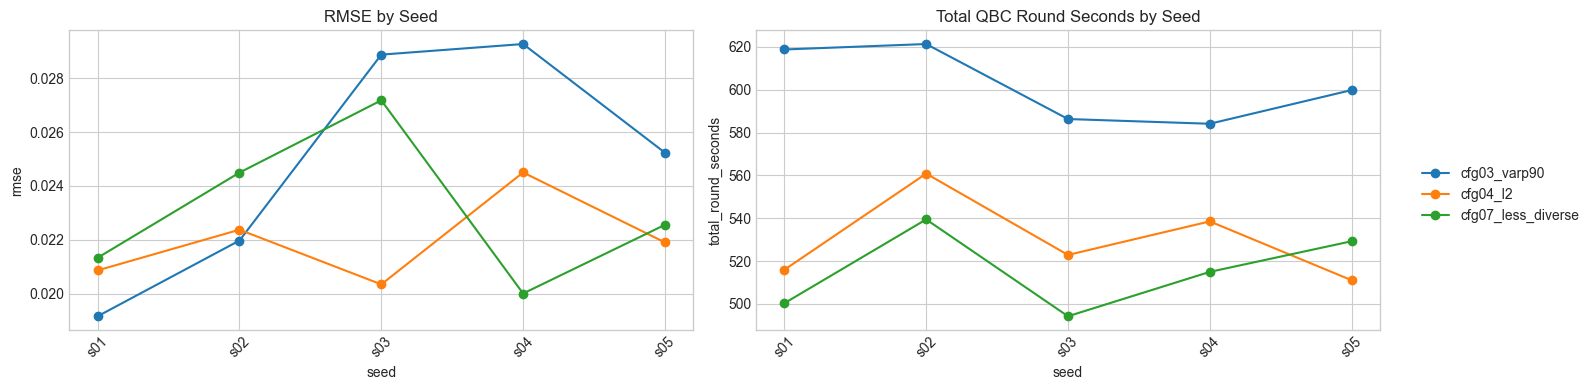

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# RMSE by seed per config
for cfg, g in stability_df.groupby('cfg'):
    g = g.sort_values('seed')
    axes[0].plot(g['seed'], g['rmse'], marker='o', label=cfg)
axes[0].set_title('RMSE by Seed')
axes[0].set_xlabel('seed')
axes[0].set_ylabel('rmse')
axes[0].tick_params(axis='x', rotation=45)

# Compute by seed per config
for cfg, g in stability_df.groupby('cfg'):
    g = g.sort_values('seed')
    axes[1].plot(g['seed'], g['total_round_seconds'], marker='o', label=cfg)
axes[1].set_title('Total QBC Round Seconds by Seed')
axes[1].set_xlabel('seed')
axes[1].set_ylabel('total_round_seconds')
axes[1].tick_params(axis='x', rotation=45)

handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.01, 0.5))
fig.tight_layout()
plt.show()

## 4) Per-Round Behavior for Best Config

In [22]:
best_runs = stability_df[stability_df['cfg'] == best_cfg].copy()
if best_runs.empty:
    raise RuntimeError(f'No runs found for best config: {best_cfg}')

tele_rows = []
for _, r in best_runs.iterrows():
    tp = Path(r['run_root']) / 'telemetry' / 'round_telemetry.csv'
    if not tp.exists():
        continue
    t = pd.read_csv(tp)
    t['cfg'] = r['cfg']
    t['seed'] = r['seed']
    t['run_name'] = r['run_name']
    tele_rows.append(t)

if not tele_rows:
    raise RuntimeError('No round telemetry found for best config runs.')

best_tele = pd.concat(tele_rows, ignore_index=True)
best_tele['round_idx'] = pd.to_numeric(best_tele['round_idx'], errors='coerce')

for c in ['mean_score', 'p90_score', 'selected_mean_score', 'selected_min_score', 'selected_max_score',
          'eval_rmse', 'acquisition_seconds', 'round_seconds']:
    if c in best_tele.columns:
        best_tele[c] = pd.to_numeric(best_tele[c], errors='coerce')

best_tele.head()

,run_id,method,budget,seed_label,round_idx,train_size_before,selected_count,disagreement_metric,mean_disagreement,max_disagreement,mean_score,max_score,p90_score,selected_mean_score,selected_min_score,selected_max_score,preselect_size,eval_mse,eval_rmse,marker_pca_components,hybrid_marker_pca_components,marker_diversity_weight,marker_sparsity_weight,mean_selected_to_train_distance,mean_marker_diversity,p90_marker_diversity,max_marker_diversity,mean_marker_sparsity,p90_marker_sparsity,max_marker_sparsity,mean_selected_marker_diversity,mean_selected_marker_sparsity,mean_selected_hybrid_diversity,mean_selected_hybrid_sparsity,mean_selected_hybrid_uncertainty,mean_selected_hybrid_score,train_seconds,candidate_generation_seconds,candidate_simulation_seconds,acquisition_seconds,selected_simulation_seconds,eval_seconds,round_seconds,cfg,seed,run_name
0,qbc_deep_ensemble_b4096_s01,qbc_deep_ensemble,b4096,s01,0,512,256,member_l2_mean,0.189181,0.419075,0.189181,0.419075,0.237563,0.232961,0.156046,0.419075,NaN,0.000250,0.015827,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.477890,0.000439,0.0,1.529840,0.126532,0.004957,10.148170,cfg04_l2,s01,cfg04_l2_s01
1,qbc_deep_ensemble_b4096_s01,qbc_deep_ensemble,b4096,s01,1,768,256,member_l2_mean,0.135275,0.255259,0.135275,0.255259,0.164588,0.160401,0.118743,0.255259,NaN,0.000074,0.008589,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.344655,0.000541,0.0,1.534411,0.131826,0.006782,14.025113,cfg04_l2,s01,cfg04_l2_s01
2,qbc_deep_ensemble_b4096_s01,qbc_deep_ensemble,b4096,s01,2,1024,256,member_l2_mean,0.213649,0.315163,0.213649,0.315163,0.268110,0.264116,0.188946,0.315163,NaN,0.000053,0.007274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.030955,0.000509,0.0,1.552460,0.129249,0.004732,17.727446,cfg04_l2,s01,cfg04_l2_s01
3,qbc_deep_ensemble_b4096_s01,qbc_deep_ensemble,b4096,s01,3,1280,256,member_l2_mean,0.174721,0.263000,0.174721,0.263000,0.203749,0.201884,0.147211,0.263000,NaN,0.000026,0.005068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.004268,0.000999,0.0,1.553757,0.132701,0.005108,21.703132,cfg04_l2,s01,cfg04_l2_s01
4,qbc_deep_ensemble_b4096_s01,qbc_deep_ensemble,b4096,s01,4,1536,256,member_l2_mean,0.182810,0.274383,0.182810,0.274383,0.227298,0.227171,0.179688,0.274383,NaN,0.000046,0.006762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.532857,0.000383,0.0,1.521025,0.121385,0.004491,26.185163,cfg04_l2,s01,cfg04_l2_s01


In [23]:
# Round-wise central tendency across seeds for best config
round_summary = (
    best_tele
    .groupby('round_idx', as_index=False)
    .agg(
        mean_score_mean=('mean_score', 'mean'),
        mean_score_std=('mean_score', 'std'),
        p90_score_mean=('p90_score', 'mean'),
        selected_mean_score_mean=('selected_mean_score', 'mean'),
        selected_min_score_mean=('selected_min_score', 'mean'),
        selected_max_score_mean=('selected_max_score', 'mean'),
        eval_rmse_mean=('eval_rmse', 'mean'),
        acq_sec_mean=('acquisition_seconds', 'mean'),
        round_sec_mean=('round_seconds', 'mean'),
        selected_count_mean=('selected_count', 'mean'),
        train_size_before_mean=('train_size_before', 'mean'),
    )
    .sort_values('round_idx')
)

round_summary

,round_idx,mean_score_mean,mean_score_std,p90_score_mean,selected_mean_score_mean,selected_min_score_mean,selected_max_score_mean,eval_rmse_mean,acq_sec_mean,round_sec_mean,selected_count_mean,train_size_before_mean
0,0,0.205312,0.018119,0.253995,0.249726,0.167924,0.441878,0.014265,1.551746,10.107644,256.0,512.0
1,1,0.155065,0.024848,0.189738,0.186143,0.136523,0.260429,0.008708,1.540996,13.885770,256.0,768.0
2,2,0.159969,0.033365,0.208467,0.204269,0.138902,0.268905,0.007185,1.533642,17.804378,256.0,1024.0
3,3,0.166895,0.012361,0.202376,0.200055,0.143513,0.250886,0.005760,1.561923,21.898906,256.0,1280.0
4,4,0.154273,0.059349,0.203086,0.199467,0.135342,0.266460,0.004904,1.543557,27.036131,256.0,1536.0
5,5,0.137858,0.040933,0.171364,0.168242,0.122638,0.218472,0.004665,1.563608,31.414326,256.0,1792.0
6,6,0.133419,0.016767,0.172347,0.168072,0.116227,0.218347,0.003642,1.560660,34.564956,256.0,2048.0
7,7,0.135675,0.017012,0.162853,0.159300,0.121302,0.211250,0.003693,1.566323,39.540061,256.0,2304.0
8,8,0.105049,0.020495,0.139571,0.135599,0.088024,0.186504,0.003639,1.550926,48.858977,256.0,2560.0
9,9,0.156393,0.082955,0.205480,0.202451,0.160328,0.243505,0.004095,1.551060,49.171770,256.0,2816.0


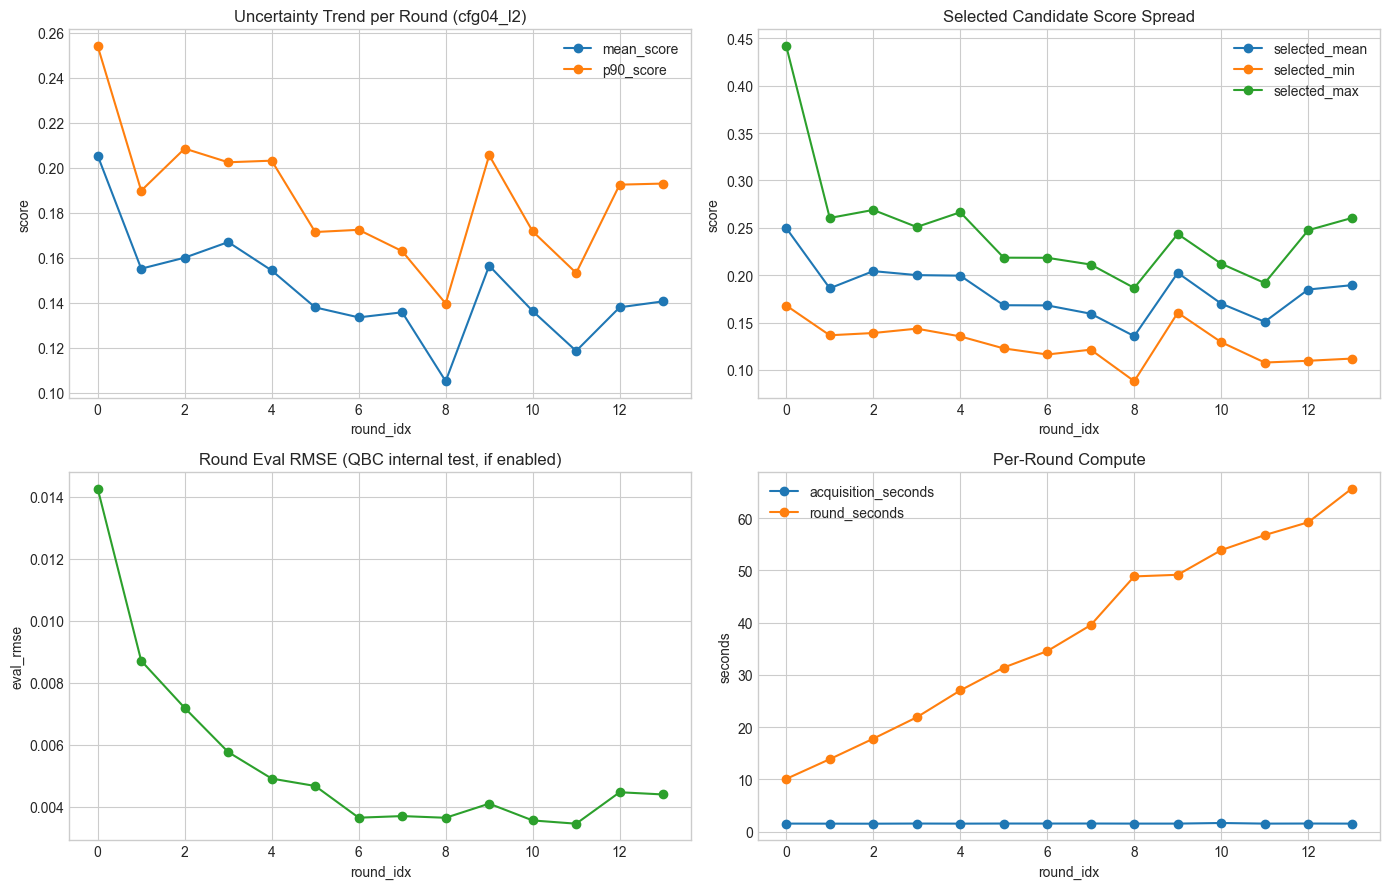

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(14, 9))

# Uncertainty scores
axes[0,0].plot(round_summary['round_idx'], round_summary['mean_score_mean'], marker='o', label='mean_score')
if 'p90_score_mean' in round_summary:
    axes[0,0].plot(round_summary['round_idx'], round_summary['p90_score_mean'], marker='o', label='p90_score')
axes[0,0].set_title(f'Uncertainty Trend per Round ({best_cfg})')
axes[0,0].set_xlabel('round_idx')
axes[0,0].set_ylabel('score')
axes[0,0].legend()

# Selected scores spread
axes[0,1].plot(round_summary['round_idx'], round_summary['selected_mean_score_mean'], marker='o', label='selected_mean')
axes[0,1].plot(round_summary['round_idx'], round_summary['selected_min_score_mean'], marker='o', label='selected_min')
axes[0,1].plot(round_summary['round_idx'], round_summary['selected_max_score_mean'], marker='o', label='selected_max')
axes[0,1].set_title('Selected Candidate Score Spread')
axes[0,1].set_xlabel('round_idx')
axes[0,1].set_ylabel('score')
axes[0,1].legend()

# Quality trend (if available)
axes[1,0].plot(round_summary['round_idx'], round_summary['eval_rmse_mean'], marker='o', color='tab:green')
axes[1,0].set_title('Round Eval RMSE (QBC internal test, if enabled)')
axes[1,0].set_xlabel('round_idx')
axes[1,0].set_ylabel('eval_rmse')

# Compute trend
axes[1,1].plot(round_summary['round_idx'], round_summary['acq_sec_mean'], marker='o', label='acquisition_seconds')
axes[1,1].plot(round_summary['round_idx'], round_summary['round_sec_mean'], marker='o', label='round_seconds')
axes[1,1].set_title('Per-Round Compute')
axes[1,1].set_xlabel('round_idx')
axes[1,1].set_ylabel('seconds')
axes[1,1].legend()

fig.tight_layout()
plt.show()

## 5) Compare Per-Round Dynamics Across All Configs

In [25]:
all_tele_rows = []
for _, r in stability_df.iterrows():
    tp = Path(r['run_root']) / 'telemetry' / 'round_telemetry.csv'
    if not tp.exists():
        continue
    t = pd.read_csv(tp)
    t['cfg'] = r['cfg']
    t['seed'] = r['seed']
    all_tele_rows.append(t)

all_tele = pd.concat(all_tele_rows, ignore_index=True)
all_tele['round_idx'] = pd.to_numeric(all_tele['round_idx'], errors='coerce')
all_tele['mean_score'] = pd.to_numeric(all_tele.get('mean_score', np.nan), errors='coerce')
all_tele['selected_mean_score'] = pd.to_numeric(all_tele.get('selected_mean_score', np.nan), errors='coerce')
all_tele['round_seconds'] = pd.to_numeric(all_tele.get('round_seconds', np.nan), errors='coerce')

cfg_round = (
    all_tele
    .groupby(['cfg', 'round_idx'], as_index=False)
    .agg(
        mean_score=('mean_score', 'mean'),
        selected_mean_score=('selected_mean_score', 'mean'),
        round_seconds=('round_seconds', 'mean'),
    )
)

cfg_round.head()

,cfg,round_idx,mean_score,selected_mean_score,round_seconds
0,cfg03_varp90,0,0.000150,0.000212,12.191112
1,cfg03_varp90,1,0.000130,0.000208,15.927110
2,cfg03_varp90,2,0.000103,0.000154,20.187521
3,cfg03_varp90,3,0.000079,0.000130,25.824837
4,cfg03_varp90,4,0.000101,0.000174,30.448200


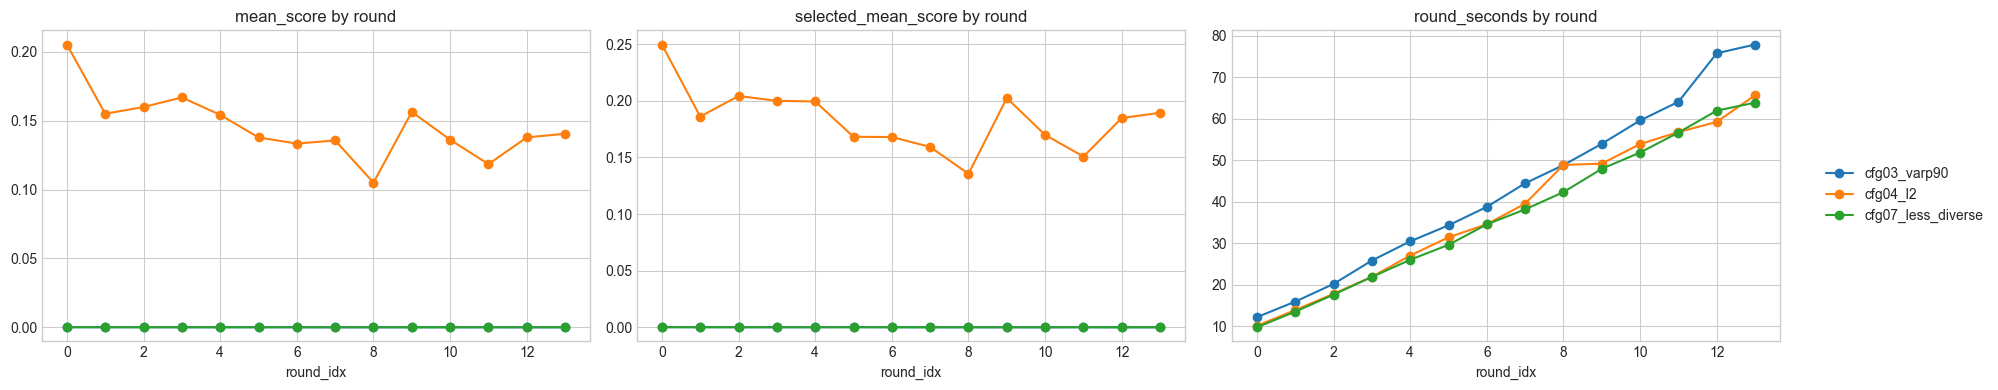

In [26]:
# Overlay plots for config-level round dynamics
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
for cfg, g in cfg_round.groupby('cfg'):
    g = g.sort_values('round_idx')
    axes[0].plot(g['round_idx'], g['mean_score'], marker='o', label=cfg)
    axes[1].plot(g['round_idx'], g['selected_mean_score'], marker='o', label=cfg)
    axes[2].plot(g['round_idx'], g['round_seconds'], marker='o', label=cfg)

axes[0].set_title('mean_score by round')
axes[1].set_title('selected_mean_score by round')
axes[2].set_title('round_seconds by round')
for ax in axes:
    ax.set_xlabel('round_idx')

handles, labels = axes[2].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.01, 0.5))
fig.tight_layout()
plt.show()

## 6) Final Recommendation Table

In [27]:
# Decision-oriented table
decision = agg.copy()
decision['rank'] = np.arange(1, len(decision) + 1)
cols = ['rank', 'cfg', 'n_seeds', 'mean_rmse', 'std_rmse', 'mean_round_seconds', 'robust_obj']
decision = decision[cols]

display(decision)
print(f'Recommended best config: {best_cfg}')

,rank,cfg,n_seeds,mean_rmse,std_rmse,mean_round_seconds,robust_obj
0,1,cfg04_l2,5,0.021997,0.001617,529.819325,0.211038
1,2,cfg07_less_diverse,5,0.023115,0.002813,515.608797,0.211940
2,3,cfg03_varp90,5,0.024906,0.004380,602.115248,0.219159


Recommended best config: cfg04_l2
